[View in Colaboratory](https://colab.research.google.com/github/peaelle42/DNN_jump_start/blob/master/JS03_03_Using_the_same_type_of_network_for_a_Different_problem_.ipynb)

## Testing for GPU - currently NO GPU is better


To Test if you have GPU set up

Run the Cell below

if no GPU is found press Runtime (in the menu at the top) and choose "Change Runtime Type" to GPU

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow.python.keras
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.optimizers import Adam

import tensorflow as tf
import numpy as np

import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

In [3]:
print(tf.keras.__version__)
print(tf.__version__)

2.1.6-tf
1.9.0-rc2


In [4]:

!ls

datalab        diagram3c.gif  diagram5g.png  notebook1.zip    solutions
diagram12.gif  diagram4f.png  diagram6d.png  notebook1.zip.1  sutils.py


### Lets import our dataset

In [5]:
! wget -qq https://www.dropbox.com/s/0e73s4u6m7winpd/imdb_data.zip
  
!unzip -qq imdb_data.zip
!rm imdb_data.zip
!rm -r __MACOSX

!ls

datalab        diagram4f.png  imdb_data        solutions
diagram12.gif  diagram5g.png  notebook1.zip    sutils.py
diagram3c.gif  diagram6d.png  notebook1.zip.1


In [0]:
reviews = pd.read_csv('./imdb_data/reviews.txt', header=None)
labels = pd.read_csv('./imdb_data/labels_ohe.csv', header=None)

In [7]:
len(reviews)

25000

In [8]:
reviews.head()
reviews[0][2]

'homelessness  or houselessness as george carlin stated  has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school  work  or vote for the matter . most people think of the homeless as just a lost cause while worrying about things such as racism  the war on iraq  pressuring kids to succeed  technology  the elections  inflation  or worrying if they  ll be next to end up on the streets .  br    br   but what if you were given a bet to live on the streets for a month without the luxuries you once had from a home  the entertainment sets  a bathroom  pictures on the wall  a computer  and everything you once treasure to see what it  s like to be homeless  that is goddard bolt  s lesson .  br    br   mel brooks  who directs  who stars as bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival  jeffery tambor  to see if he can live in the streets for thirty days w

In [9]:

labels[:5]
# 0 = bad 1 = good

,0,1
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0


Counting the words in the dataset

In [10]:
total_counts = Counter()
for i,row in reviews.iterrows():
    total_counts.update(row[0].split(' '))

print("Total words in data set: ", len(total_counts))

Total words in data set:  74074


Just keeping the 10k most frequent words

In [11]:
vocab = sorted(total_counts, key=total_counts.get, reverse=True)[:10000]
print(vocab[40:50])

['like', 'there', 'her', 'or', 'just', 'about', 'out', 'if', 'has', 'what']


In [1]:
print(vocab[0], ': ', total_counts[vocab[1]])

NameError: ignored

### Making our word index table

we can input a word it gives back the number

In [0]:
word2idx = {word: i for i, word in enumerate(vocab)} #dictionary comprehension 

In [17]:
word2idx['was']

15

Convert the a review to a vector of words 10k long

In [0]:
def text_to_vector(text):
    word_vector = np.zeros(len(vocab), dtype=np.int_)
    for word in text.split(' '):
        idx = word2idx.get(word,None)
        if idx is None:
            continue
        else:
            word_vector[idx] = 1 # was += 1
    return np.array(word_vector)

In [19]:
text_to_vector('There were lots of good movies and stars this year')[:65]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
test_word_vector = text_to_vector('There were lots of good movies and stars this year')
test_word_vector.shape

(10000,)

Now do that for the whole corpus

In [0]:
word_vectors = np.zeros((len(reviews), len(vocab)), dtype=np.int_)
for ii, (_, text) in enumerate(reviews.iterrows()):
    word_vectors[ii] = text_to_vector(text[0])

In [22]:
# Printing out the first 3 word vectors
print(word_vectors[:3, :25])
print(reviews[:3])

[[1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1]]
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...


Lets see what our tensor looks like

In [23]:
word_vectors.shape

(25000, 10000)

In [25]:

number_of_records = len(labels)
shuffle = np.arange(number_of_records)
np.random.shuffle(shuffle)
test_fraction = 0.8

#print(int(number_of_records*test_fraction))

#making a train / test split
train_split, test_split = shuffle[:int(number_of_records*test_fraction)], shuffle[int(number_of_records*test_fraction):]
x_train, y_train = word_vectors[train_split,:], labels.values[train_split,:]
x_test, y_test = word_vectors[test_split,:], labels.values[test_split]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
type(x_test[0][0])

(20000, 10000)
(20000, 2)
(5000, 10000)
(5000, 2)


numpy.int64

In [0]:
x_train, x_test, y_train, y_test = train_test_split(word_vectors,labels.values,test_size=0.2)

In [27]:
x_test[0].shape

(10000,)

In [28]:
print("x_train :",x_train.shape)
print("y_train :",y_train.shape)
print("x_test :",x_test.shape)
print("y_test :",y_test.shape)
type(x_test[0][0])

x_train : (20000, 10000)
y_train : (20000, 2)
x_test : (5000, 10000)
y_test : (5000, 2)


numpy.int64

In [0]:
# Training Parameters for basic MNIST
learning_rate = 0.1 
training_epochs = 10
batch_size = 100

# Network Parameters
n_input = 10000 # MNIST data input (img shape: 28*28 flattened to be 784)
n_hidden_1 = 100 # 1st layer number of neurons
n_hidden_2 = 100 # 2nd layer number of neurons
n_hidden_3 = 100 # 2nd layer number of neurons
n_classes = 2 # MNIST classes for prediction(digits 0-9 )

In [0]:
Inp = Input(shape=(n_input,))
x = Dense(n_hidden_1, activation='relu', name = "Dense_1")(Inp)
x = Dropout(0.5, name = "Dropout_01")(x)
x = Dense(n_hidden_2, activation='relu', name = "Dense_2")(x)
x = Dropout(0.3, name = "Dropout_02")(x)
x = Dense(n_hidden_3, activation='relu', name = "Dense_3")(x)
output = Dense(n_classes, activation='softmax', name = "Outputlayer")(x)


In [0]:
model = Model(Inp, output)

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 100)               1000100   
_________________________________________________________________
Dropout_01 (Dropout)         (None, 100)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dropout_02 (Dropout)         (None, 100)               0         
_________________________________________________________________
Dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
Outputlayer (Dense)          (None, 2)                 202       
Total para

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [35]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=1, # This is for what we want it to display out as it trains 
                    validation_data=(x_test, y_test))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 204us/step - loss: 0.3946 - acc: 0.8155 - val_loss: 0.2643 - val_acc: 0.8892
Epoch 2/10
20000/20000 [==============================] - 4s 188us/step - loss: 0.2160 - acc: 0.9185 - val_loss: 0.2911 - val_acc: 0.8870
Epoch 3/10
20000/20000 [==============================] - 4s 208us/step - loss: 0.1456 - acc: 0.9470 - val_loss: 0.3150 - val_acc: 0.8786
Epoch 4/10
20000/20000 [==============================] - 4s 216us/step - loss: 0.1027 - acc: 0.9636 - val_loss: 0.3830 - val_acc: 0.8828
Epoch 5/10
 5100/20000 [======>.......................] - ETA: 2s - loss: 0.0774 - acc: 0.9722

20000/20000 [==============================] - 4s 214us/step - loss: 0.0813 - acc: 0.9707 - val_loss: 0.4019 - val_acc: 0.8820
Epoch 6/10
20000/20000 [==============================] - 4s 201us/step - loss: 0.0608 - acc: 0.9786 - val_loss: 0.4470 - val_acc: 0.8792
Epoch 7/10
20000/20000 [==============================] - 4s 180us/step - loss: 0.0544 - acc: 0.9809 - val_loss: 0.4407 - val_acc: 0.8808
Epoch 8/10
20000/20000 [==============================] - 3s 174us/step - loss: 0.0493 - acc: 0.9813 - val_loss: 0.4759 - val_acc: 0.8734
Epoch 9/10
20000/20000 [==============================] - 3s 161us/step - loss: 0.0461 - acc: 0.9833 - val_loss: 0.5080 - val_acc: 0.8788
Epoch 10/10
  500/20000 [..............................] - ETA: 2s - loss: 0.0347 - acc: 0.9880

20000/20000 [==============================] - 3s 160us/step - loss: 0.0398 - acc: 0.9846 - val_loss: 0.5049 - val_acc: 0.8770


In [0]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

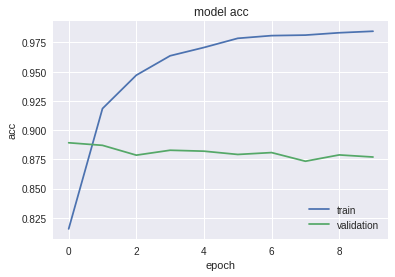

In [37]:
plot_train(history)

In [0]:
preds = model.predict(x_test[10:15])

In [39]:
preds

array([[9.4399340e-08, 9.9999988e-01],
       [9.9974769e-01, 2.5226679e-04],
       [6.8898112e-06, 9.9999309e-01],
       [9.9267769e-01, 7.3223421e-03],
       [9.9814701e-01, 1.8530507e-03]], dtype=float32)

In [40]:
y_test[10:15]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [0]:
preds = model.predict_on_batch(x_test[10:15])

In [43]:
reviews[0][0]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   '